In [14]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Set style for better visualizations
sns.set_style("whitegrid")  # Changed from plt.style.use('seaborn')
plt.style.use('default')    # Use default matplotlib style

# For reproducibility
np.random.seed(42)

In [15]:
def load_stock_data(ticker="AAPL", start_date="2017-01-01", end_date="2025-01-01"):
    """
    Load stock data for a given ticker using yfinance
    """
    # Download data
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    if len(stock) > 0:
        print(f"\nSuccessfully downloaded data for {ticker}:")
        print(f"Shape: {stock.shape}")
        print(f"Columns: {list(stock.columns)}")
        print(f"Date range: {stock.index[0]} to {stock.index[-1]}")
        
        # Verify data types
        print("\nData types:")
        print(stock.dtypes)
        
        return stock
    else:
        raise ValueError(f"No data downloaded for {ticker}")

In [16]:
def create_features(df):
    """
    Create technical indicators and features for stock prediction
    """
    df = df.copy()
    
    # Technical Indicators
    # 1. Moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # 2. Price momentum
    df['Returns'] = df['Close'].pct_change()
    df['Returns_5'] = df['Close'].pct_change(periods=5)
    
    # 3. Trading volume features
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    
    # 4. Volatility
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    
    # 5. Price range
    # Make sure to use .values or .to_numpy() to avoid DataFrame operations
    df['Daily_Range'] = (df['High'] - df['Low']).values
    df['Daily_Range_Pct'] = ((df['High'] - df['Low']) / df['Close']).values
    
    # Drop NaN values created by rolling windows
    df = df.dropna()
    
    # Print shape of data after feature creation
    print(f"\nFeature creation complete:")
    print(f"Shape of data: {df.shape}")
    print(f"Features created: {list(df.columns)}")
    
    return df

In [17]:
def prepare_data(df, target_col='Close', sequence_length=60, train_split=0.8):
    """
    Prepare data for time series prediction with explicit 80/20 split
    """
    # Select features for prediction
    feature_columns = ['Close', 'Volume', 'Returns', 'MA5', 'MA20', 'MA50', 
                      'Volume_MA5', 'Volume_MA20', 'Volatility', 'Daily_Range_Pct']
    
    # Scale features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit scalers
    data_scaled = scaler_X.fit_transform(df[feature_columns])
    target_scaled = scaler_y.fit_transform(df[[target_col]])
    
    # Create sequences
    X, y = [], []
    for i in range(len(data_scaled) - sequence_length):
        X.append(data_scaled[i:(i + sequence_length)])
        y.append(target_scaled[i + sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # Calculate split index for exact 80/20 split
    split_idx = int(len(X) * 0.8)
    
    # Split into train and test sets
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Print dataset information
    print("\nDataset Split Information:")
    print(f"Total sequences: {len(X)}")
    print(f"Training sequences: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Testing sequences: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, (scaler_X, scaler_y)

In [18]:
# Load data
ticker = "AAPL"
print(f"Downloading data for {ticker}...")
df = load_stock_data(ticker, start_date="2017-01-01", end_date="2024-01-01")  # Note: Changed end date to 2024

# Create features
print("\nCreating features...")
df_features = create_features(df)

# Verify data before preparing
print("\nVerifying data before preparation:")
print(f"Shape: {df_features.shape}")
print(f"Columns: {list(df_features.columns)}")
print(f"First few rows:\n{df_features.head()}")

# Prepare data for modeling with 80/20 split
X_train, y_train, X_test, y_test, scalers = prepare_data(df_features, train_split=0.8)


Successfully downloaded data for AAPL:
Shape: (1760, 5)
Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Date range: 2017-01-03 00:00:00 to 2023-12-29 00:00:00

Data types:
Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object

Creating features...

Feature creation complete:
Shape of data: (1711, 15)
Features created: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('MA5', ''), ('MA20', ''), ('MA50', ''), ('Returns', ''), ('Returns_5', ''), ('Volume_MA5', ''), ('Volume_MA20', ''), ('Volatility', ''), ('Daily_Range', ''), ('Daily_Range_Pct', '')]

Verifying data before preparation:
Shape: (1711, 15)
Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('MA5', ''), ('MA20', ''), ('MA50', ''), ('Returns', ''), ('Returns_5', ''), ('Volume_M

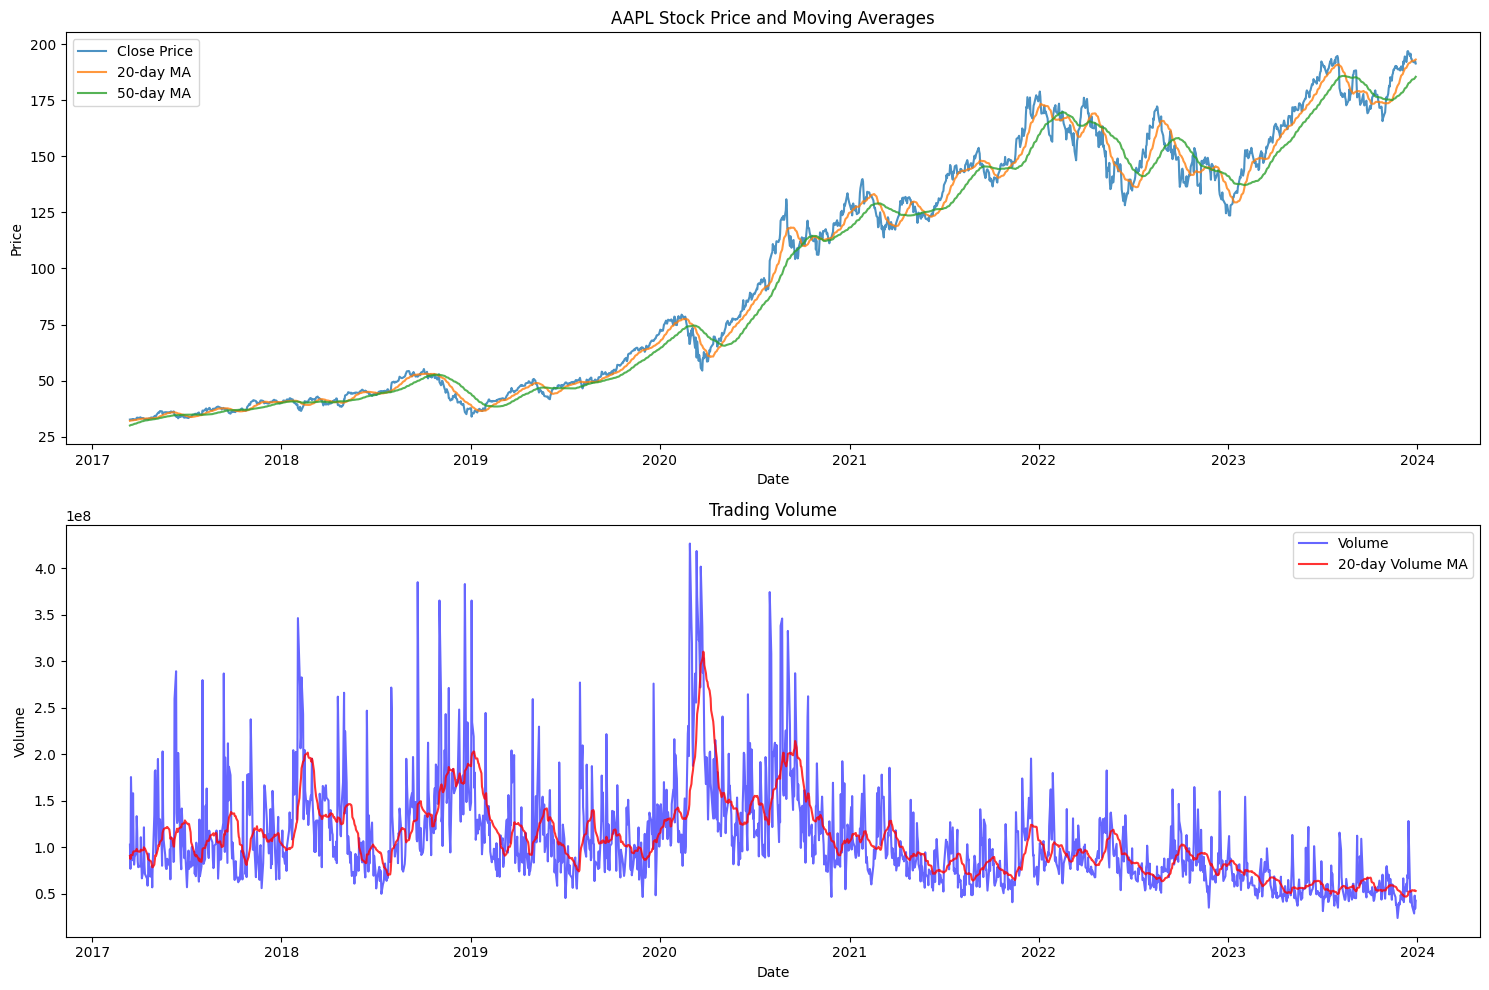

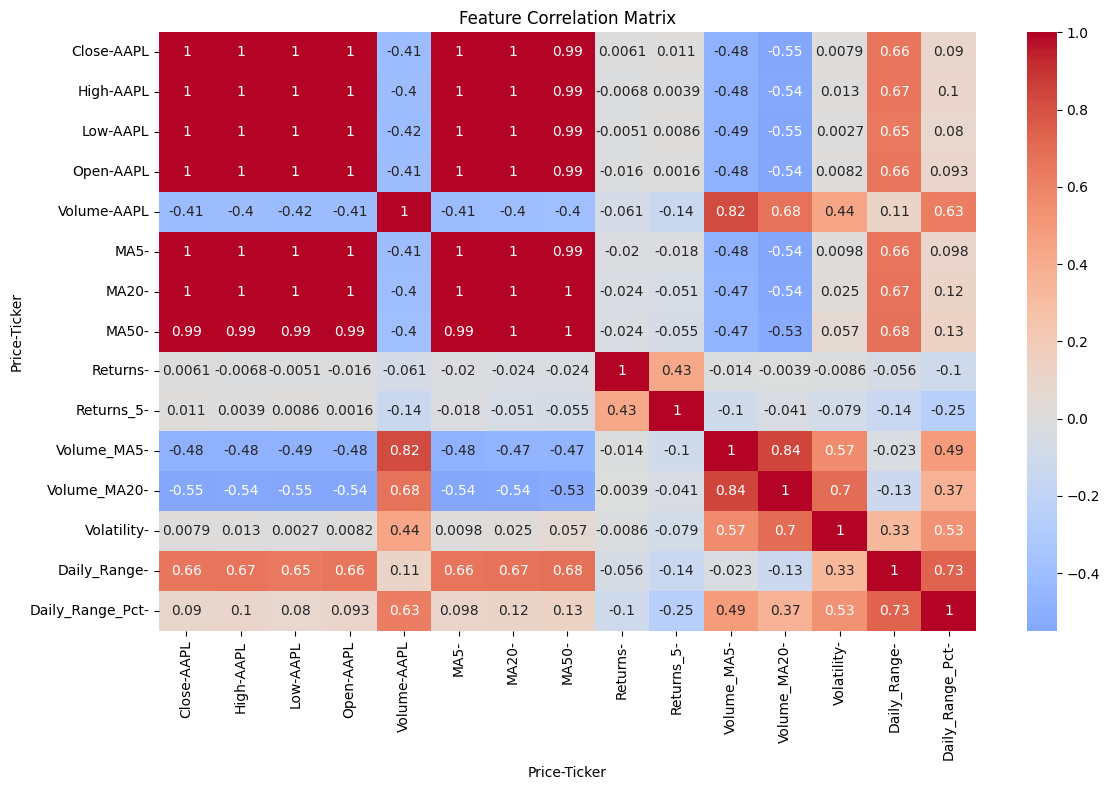

In [19]:
# Visualize the stock price history and features
plt.figure(figsize=(15, 10))

# Plot 1: Stock Price and Moving Averages
plt.subplot(2, 1, 1)
plt.plot(df_features.index, df_features[('Close', 'AAPL')], label='Close Price', alpha=0.8)
plt.plot(df_features.index, df_features[('MA20', '')], label='20-day MA', alpha=0.8)
plt.plot(df_features.index, df_features[('MA50', '')], label='50-day MA', alpha=0.8)
plt.title('AAPL Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot 2: Volume
plt.subplot(2, 1, 2)
plt.plot(df_features.index, df_features[('Volume', 'AAPL')], label='Volume', color='blue', alpha=0.6)
plt.plot(df_features.index, df_features[('Volume_MA20', '')], label='20-day Volume MA', color='red', alpha=0.8)
plt.title('Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation Analysis
plt.figure(figsize=(12, 8))
correlation_matrix = df_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

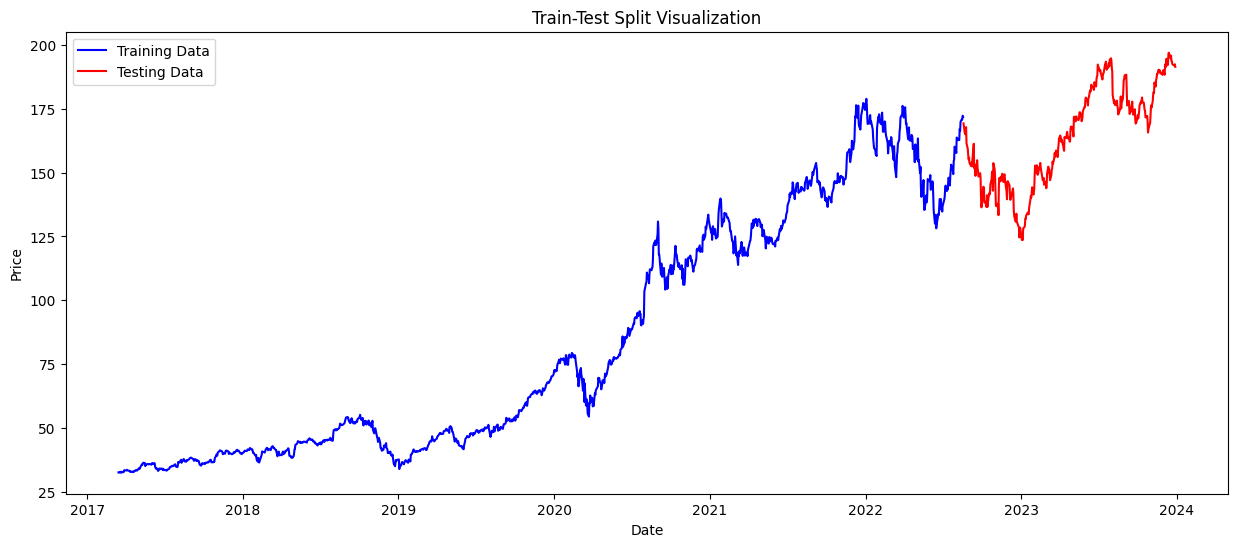

In [20]:
# Visualize the train-test split
plt.figure(figsize=(15, 6))
split_idx = int(len(df_features) * 0.8)

# Plot the split on the original price data
plt.plot(df_features.index[:split_idx], 
         df_features[('Close', 'AAPL')][:split_idx], 
         label='Training Data', 
         color='blue')
plt.plot(df_features.index[split_idx:], 
         df_features[('Close', 'AAPL')][split_idx:], 
         label='Testing Data', 
         color='red')

plt.title('Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

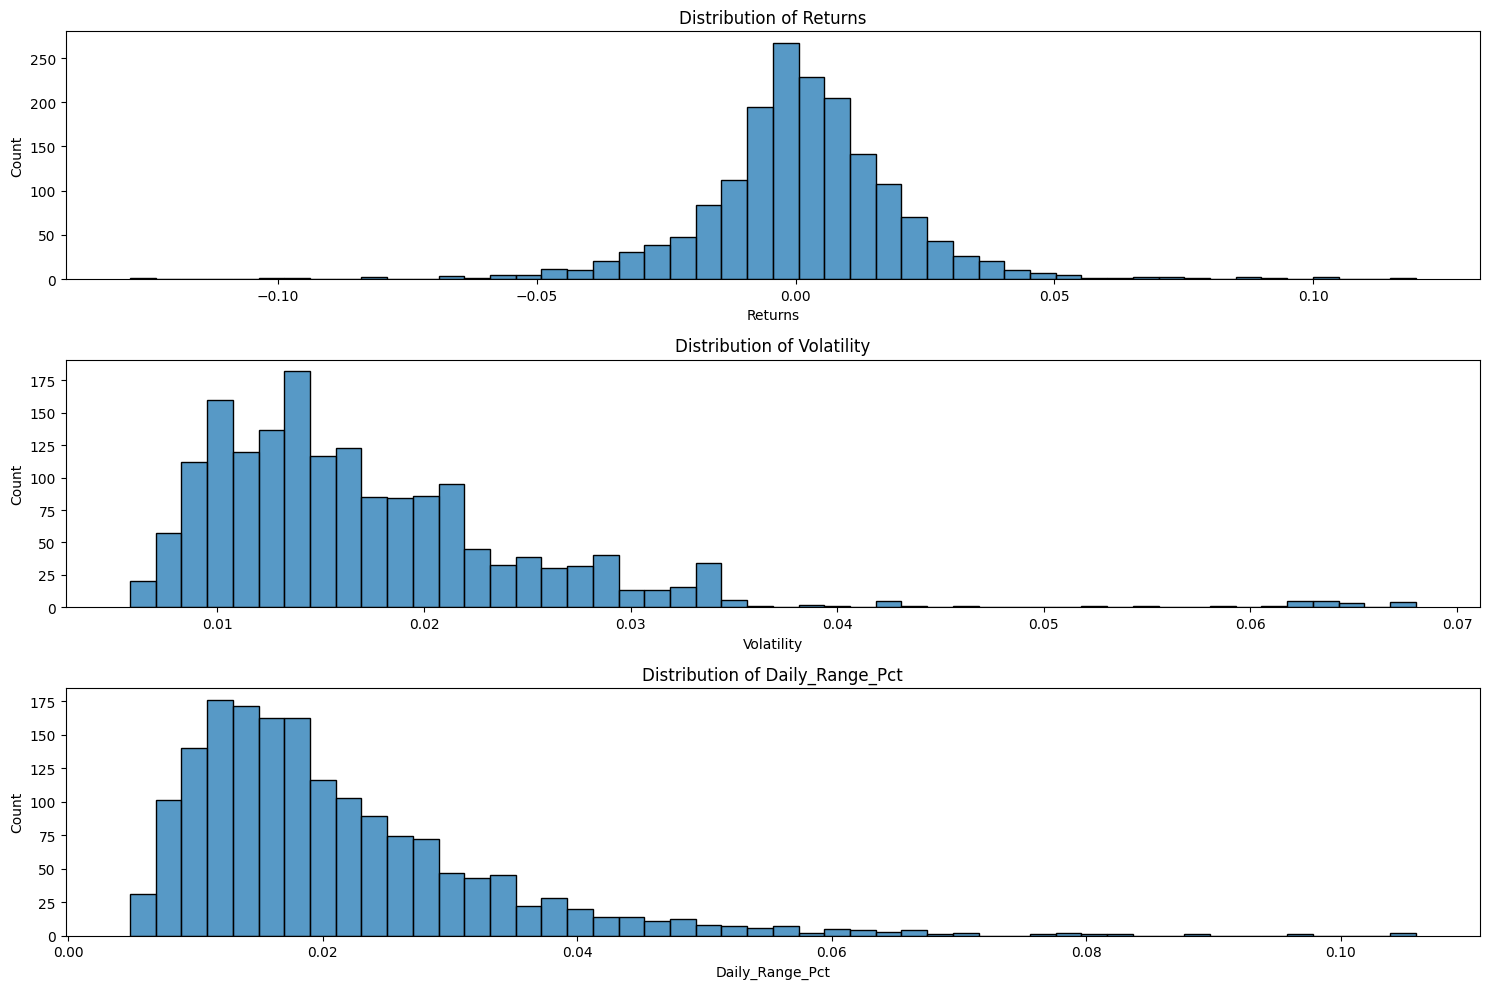

In [21]:
# Analyze feature distributions
plt.figure(figsize=(15, 10))
features_to_plot = [('Returns', ''), ('Volatility', ''), ('Daily_Range_Pct', '')]

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 1, i)
    sns.histplot(df_features[feature], bins=50)
    plt.title(f'Distribution of {feature[0]}')
    plt.xlabel(feature[0])
    
plt.tight_layout()
plt.show()

In [26]:
# Calculate and display summary statistics
print("\nSummary Statistics:")
print(df_features.describe())

# Display data quality information
print("\nData Quality Check:")
print("Missing values:")
print(df_features.isnull().sum())


Summary Statistics:
Price         Close         High          Low         Open        Volume  \
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL   
count   1711.000000  1711.000000  1711.000000  1711.000000  1.711000e+03   
mean      99.717234   100.741818    98.588791    99.627993  1.074127e+08   
std       53.303406    53.832598    52.717912    53.255496  5.377833e+07   
min       32.481514    32.692893    32.198133    32.376987  2.404830e+07   
25%       45.181166    45.473690    44.798626    45.151241  7.231535e+07   
50%      106.033638   107.836764   104.111285   105.729956  9.397040e+07   
75%      147.152550   148.681904   145.707226   146.951395  1.278438e+08   
max      196.927658   198.428641   195.824294   196.838199  4.265100e+08   

Price           MA5         MA20         MA50      Returns    Returns_5  \
Ticker                                                                    
count   1711.000000  1711.000000  1711.000000  1711.000000  1711.000